3605 1600
(256, 256)
[  0   0   0 ... 255 255 255] [  0   1   2 ... 253 254 255]


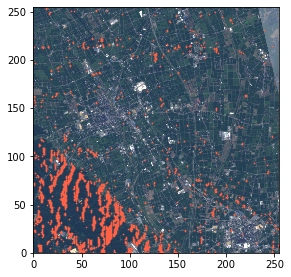

In [12]:
#ASNAROのデータはシーンを取得→シーンを引数として画像を取得、の流れ。
import os, math, requests, json #jsonとはjavascriptに似た表現形式のデータフォーマット。keyとvaluewを:で対にして記述。
from skimage import io
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
get_ipython().run_line_magic('matplotlib', 'inline')
TOKEN = ""

                    
def get_tile_num(lat_deg, lon_deg, zoom): #緯度経度からタイル座標を取得する関数
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0 ) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)
zoom = 12 # 9-17
(xtile, ytile) = get_tile_num(36.55,  136.9, zoom)
print(xtile, ytile)

def get_AVNIR_image(zoom, x, y, opacity=1, r=3, g=2, b=1, rdepth=1, gdepth=1, bdepth=1, preset=None):
    url = "https://gisapi.tellusxdp.com/blend/{}/{}/{}.png?opacity={}&r={}&g={}&b={}&rdepth={}&gdepth={}&bdepth={}".format(zoom, x, y, opacity, r, g, b, rdepth, gdepth, bdepth) 
    if preset is not None:
        url += '&preset='+preset
    headers = {
        "content-type": "application/json",
        "Authorization": "Bearer " + TOKEN
    }
    r = requests.get(url, headers=headers)
    return io.imread(BytesIO(r.content))

true_img1 = get_AVNIR_image(zoom,xtile,ytile)
io.imshow(true_img1)

#南向き斜面プロット
plt.xlim([0,255])
plt.ylim([0,255])
SouthIdo=[]
SouthKeido=[]
green_min = np.array([25,0,0]) 
green_max = np.array([75,255,255]) 
ndvi_img = get_AVNIR_image(zoom,xtile,ytile,preset='ndvi')

ido=[]
keido=[]

for index in range(256):
    f = open('./facingSouth_{}_0.txt'.format(index), 'r')
    l = [0,0,0,0]
    while l:
        l = f.readline()
        list1 = l.split(',')
        if len(list1) == 4:
            if int(list1[3]) == 1:
                ido.append(int(list1[0]))
                keido.append(index)
    f.close()

#plt.scatter(ido,keido,color='blue',s=0.5)
#plt.show()

def masking(img, hsv_min, hsv_max):
    # OpenCVで扱うために色順をRGB(RGBA)からBGRに入れ替える
    cv_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR) 
    # BGRからHSVに変換
    cv_hsv = cv2.cvtColor(cv_bgr, cv2.COLOR_BGR2HSV)
    
    # 指定した範囲の色以外を黒に変換する
    mask = cv2.inRange(cv_hsv, hsv_min, hsv_max)
    masked_img = cv2.bitwise_and(cv_bgr, cv_bgr, mask=mask)
    print(mask.shape)
    print(np.where(mask==255)[0],np.where(mask==255)[1])
        
    # 得られた画像の色順をBGRからRGBに戻す
    return cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
masked_img = masking(ndvi_img, green_min, green_max)
sansai = []
for index in range(len(ido)):
    if not np.all(masked_img[keido[index],ido[index]] == np.array([0,0,0],dtype='uint8')):
        sansai.append([ido[index],keido[index]])
plt.scatter(np.array(sansai)[:,0], np.array(sansai)[:,1], color='tomato', s=0.5)
plt.show()